In [1]:
import gym
from collections import namedtuple
import numpy as np
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
# actions = [0, 1] = [-1, 1]

class Game:
    def __init__(self, angle_degree, distance):
        self.angle_degree = angle_degree
        self.distance = distance
        self.velocity = random.randint(1, 200)
        self.distance_to_target = distance
        self.record_distance = distance / 4
        self.n_games = 0
        self.n_episode_games = 0
        self.epsilon = 0
        
    def reset(self):
        self.velocity = random.randint(1, 200)
        self.distance_to_target = self.distance
        self.record_distance = self.distance / 4
        self.n_episode_games = 0
#         print('reset')
        return np.array([self.angle_degree, self.distance, self.distance_to_target, self.velocity])

    def calculate_distance_to_target(self, v0, angle_degree):
        g = 9.8
        angle_radian = math.radians(angle_degree)
        distance = (v0**2 * math.sin(2 * angle_radian)) / g
        return distance
    
    def step(self, action):
        
        self.n_games += 1
        self.n_episode_games += 1

        if action == 0:
            self.velocity -= 1
        else:
            self.velocity += 1

        # move
        calc_distance = self.calculate_distance_to_target(self.velocity, self.angle_degree)

        new_distance_to_target = abs(self.distance - calc_distance)

        # reward
#         reward = abs((self.distance - distance) / distance_to_target**2)
        if new_distance_to_target < self.distance_to_target:
            self.distance_to_target = new_distance_to_target
            reward = 1
        else:
            reward = 0
            
        if new_distance_to_target < self.record_distance or new_distance_to_target > self.distance * 2 or self.n_episode_games > 100:
            self.record_distance = new_distance_to_target
            is_done = True
        else:
            is_done = False
            
        # update ui
#         print('distance_to_target', new_distance_to_target)
        
        state = np.array([self.angle_degree, self.distance, new_distance_to_target, self.velocity])

        return state, reward, is_done

In [3]:
HIDDEN_SIZE = 128
BATCH_SIZE = 100
PERCENTILE = 30
GAMMA = 0.9

In [4]:
class Net(nn.Module):
    def __init__(self, state_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )
    
    def forward(self, x):
        return self.net(x)

In [5]:
# sum of rewards in episode
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
# one step in episode
Step = namedtuple('Step', field_names=['state', 'action'])

In [6]:
def iterate_batches(env, model, batch_size):
    batch = [] 
    episode_reward = 0.0
    episode_steps = [] 
    state = env.reset()
    softmax = nn.Softmax(dim=1)
    
    while True:
        env.epsilon = 180 - env.n_games
        if random.randint(0, 1200) < env.epsilon:
            action = random.randint(0, 1)
        else:
            state_v = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            pred = model(state_v)
            act_probs_v = softmax(pred)
            act_probs = act_probs_v.data.numpy()[0]

            action = np.random.choice(len(act_probs), p=act_probs)
        
        next_state, reward, is_done = env.step(action)
        
        episode_reward += reward
        episode_steps.append(Step(state=state, action=action))
        
        if is_done:
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            episode_reward = 0.0
            episode_steps = []
            next_state = env.reset()
            
            if len(batch) == batch_size:
                yield batch
                batch = []
                
        state = next_state

In [7]:
def filter_batch(batch, percentile):
    discount_rewards = list(map(lambda s: s.reward * (GAMMA**len(s.steps)), batch))
    reward_bound = np.percentile(discount_rewards, percentile)
    
    train_states = []
    train_actions = []
    elite_batch = []
    
    for el, disc_rd in zip(batch, discount_rewards):
        if disc_rd > reward_bound:
            train_states.extend(map(lambda step: step.state, el.steps))
            train_actions.extend(map(lambda step: step.action, el.steps))
            elite_batch.append(el)
            
    train_states_v = torch.tensor(train_states, dtype=torch.float)
    train_actions_v = torch.tensor(train_actions, dtype=torch.long)
            
    return elite_batch, train_states_v, train_actions_v, reward_bound

In [8]:
random.seed(12345)

env = Game(30, 100)
state_size = 4
n_actions = 2

log_loss = []
log_reward_bound = []
log_reward_mean = []

model = Net(state_size, HIDDEN_SIZE, n_actions)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.01)

full_batch = []
for i, batch in enumerate(iterate_batches(env, model, BATCH_SIZE)):
    reward_mean = float(np.mean(list(map(lambda s: s.reward, batch))))
    full_batch, states_v, actions_v, reward_bound = filter_batch(full_batch + batch, PERCENTILE)
    
    if not full_batch:
        continue
        
    full_batch = full_batch[-500:]
    
    optimizer.zero_grad()
    
    action_scores_v = model(states_v)
    loss_v = loss_fn(action_scores_v, actions_v)
    
    loss_v.backward()
    optimizer.step()
    
    print('%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f' % (i, loss_v.item(), reward_mean, reward_bound))
    
    log_loss.append(loss_v.item())
    log_reward_bound.append(reward_bound)
    log_reward_mean.append(reward_mean)
                           

C:\Users\1rati\AppData\Local\Temp\ipykernel_17976\2123067684.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  train_states_v = torch.tensor(train_states, dtype=torch.float)


0: loss=0.087, reward_mean=4.3, reward_bound=0.0
1: loss=18.670, reward_mean=2.1, reward_bound=0.0
2: loss=1.389, reward_mean=2.2, reward_bound=0.0
3: loss=3.463, reward_mean=2.2, reward_bound=0.0
4: loss=4.042, reward_mean=3.1, reward_bound=0.0
5: loss=3.739, reward_mean=2.9, reward_bound=0.0
6: loss=3.255, reward_mean=4.4, reward_bound=0.0
7: loss=2.945, reward_mean=3.8, reward_bound=0.1
8: loss=2.477, reward_mean=3.5, reward_bound=0.1
9: loss=2.066, reward_mean=3.0, reward_bound=0.1
10: loss=2.078, reward_mean=3.1, reward_bound=0.2
11: loss=2.338, reward_mean=2.5, reward_bound=0.2
12: loss=2.290, reward_mean=0.8, reward_bound=0.1
13: loss=2.055, reward_mean=1.9, reward_bound=0.3
14: loss=1.948, reward_mean=2.9, reward_bound=0.4
15: loss=2.000, reward_mean=2.8, reward_bound=0.5
16: loss=2.062, reward_mean=3.0, reward_bound=0.6
17: loss=2.144, reward_mean=3.9, reward_bound=0.8
18: loss=1.975, reward_mean=3.2, reward_bound=0.9
19: loss=1.230, reward_mean=2.4, reward_bound=0.0
20: loss=

KeyboardInterrupt: 

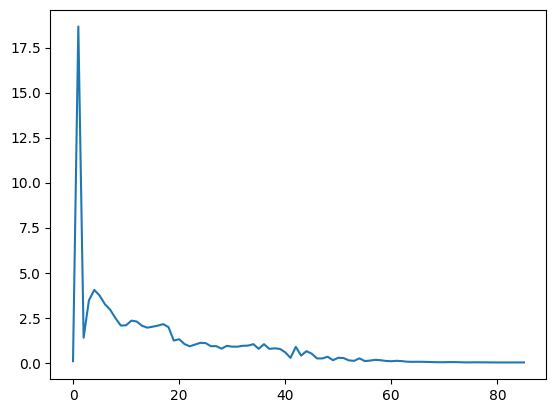

In [12]:
# loss
plt.plot(log_loss)
plt.show()

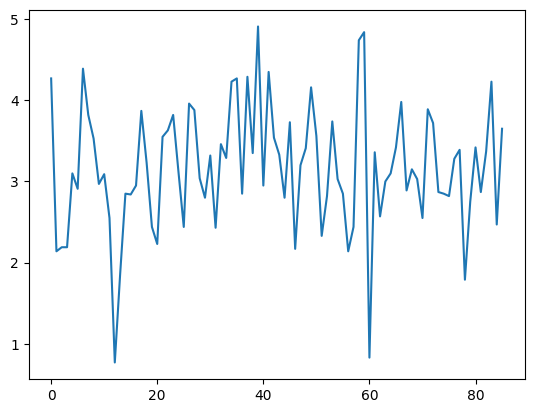

In [10]:
# mean reward
plt.plot(log_reward_mean)
plt.show()

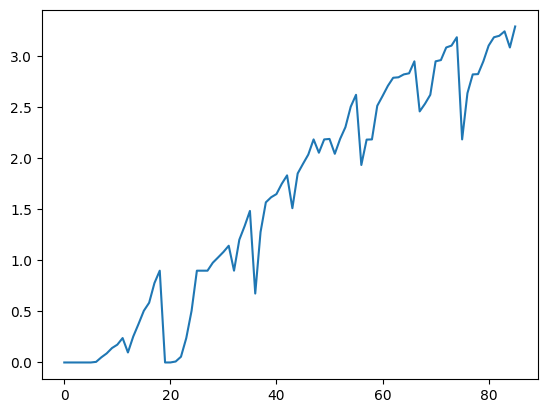

In [11]:
# bound reward
plt.plot(log_reward_bound)
plt.show()